# Sweep dating using kwarg (not part of analysis)

The strategy is to:

1. Use kwarg to extract the non-recombined region around the sweep peak.
2. Get the length of these non-recombined regions and argue that this must be sweeps based on length.
3. Use Tishkoff approach to date each sweep.

In [1]:
import re, os, sys, pickle, pickle, subprocess, bisect, random
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

from ete3 import Tree
from scipy.cluster.hierarchy import dendrogram, linkage

import pyfaidx

# my own libaries
from GenomicWindows import window
import GenomicIntervals

numpy.random.seed(7)
random.seed(7)

Parallel computing:

In [2]:
import ipyparallel
from ipyparallel import depend, require

# create client & view
rc = ipyparallel.Client()
dview = rc[:]
bview = rc.load_balanced_view() # you can set block=True to have this apply globally

# scatter 'id', so id=0,1,2 on engines 0,1,2
dview.scatter('node_id', rc.ids, flatten=True)
print("Engine IDs: ", dview['node_id'])
# create a Reference to `id`. This will be a different value on each engine
ref = ipyparallel.Reference('node_id')

with dview.sync_imports(): # imports libs across dview
    import re, os, sys, pickle, math, collections, random
    from pathlib import Path
    import numpy
    import pandas
    from pandas import DataFrame
    from ete3 import Tree
    from scipy.cluster.hierarchy import dendrogram, linkage
    import subprocess
    import bisect
    import pyfaidx

    
dview.execute('numpy.random.seed(7)')

# def scatter_func(f):
#     dview.scatter(f.__name__, [f]*len(bview), flatten=True)    

def scatter_func(*args):
    for f in args:
        dview.scatter(f.__name__, [f]*len(bview), flatten=True)    

def getmem():
    p = subprocess.Popen("echo $HOSTNAME", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = p.communicate()
    return node_id, stdout.decode().strip(), resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

def print_mem():
    for node_id, host_name, mem in  dview.apply(getmem).get():
        print("{}{: >10}{: 10.2f} Mb". format(node_id, host_name, mem))

def parallel_apply(grouped_df, fun):
    return pandas.concat(dview.map_sync(fun, (group for name, group in grouped_df)))

Engine IDs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
importing re on engine(s)
importing os on engine(s)
importing sys on engine(s)
importing pickle on engine(s)
importing math on engine(s)
importing collections on engine(s)
importing random on engine(s)
importing Path from pathlib on engine(s)
importing numpy on engine(s)
importing pandas on engine(s)
importing DataFrame from pandas on engine(s)
importing Tree from ete3 on engine(s)
importing dendrogram,linkage from scipy.cluster.hierarchy on engine(s)
importing subprocess on engine(s)
importing bisect on engine(s)
importing pyfaidx on engine(s)


In [3]:
def foo(a):
    return 1

result = dview.map_sync(foo, [1,2,3])
print(list(result))   

[1, 1, 1]


Plotting setup:

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### Analysis dirs

In [6]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

reference_genome_file = Path('/home', 'kmt', 'simons', 
                        'faststorage', 'cteam_lite_public3', 'FullyPublic', 'Href.fa')

Import variables global to the entire analysis:

In [7]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [8]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [9]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def flatten_column_index(df):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]


In [10]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

## Load meta data

In [11]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Dates using kwARG

In [12]:
with open(str(results_dir / 'sweeps_for_dating.pickle'), 'rb') as f:
    sweeps_for_dating = pickle.load(f)

In [13]:
def get_sequence_windows(sample_ids, start, end):
    assert start < end
    start, end = int(start), int(end)
    seq_list = list()
    name_list = list()

    reference_index = pyfaidx.Fasta(str(reference_genome_file), 
                                     strict_bounds=True, 
                                     one_based_attributes=False)
    file_index = dict()
    for file_path in male_x_haploid_dir.glob('*.fa'):
        name = file_path.name.split('.')[0]
        file_index[name] = pyfaidx.Fasta(str(file_path), 
                                         strict_bounds=True, 
                                         one_based_attributes=False)
    
    for sample_id in sample_ids:
        name = sample_id + '-A'   
        seq_list.append(file_index[name]['X'][start:end].seq)
        name_list.append(name.replace('-A', ''))
        
    ref = reference_index['X'][start:end].seq
    
    return name_list, seq_list, ref


def kwarg_input(start, end, indivs):
    name_list, alignment, ref = get_sequence_windows(indivs, start, end)

#     prop_missing = list()
#     for seq in alignment:
#         prop_missing.append(sum(int(base not in 'ATGC') for base in seq) / len(seq))
#     print(sorted(zip(prop_missing, name_list), reverse=True)[:10])
        
    # bin encoding of snps
    bin_encoding = list()
    for seq in alignment:
        lst = list()
        for i, base in enumerate(seq):
            if base in 'ATGC' and ref[i] in 'ATGC':
                if base != ref[i]:
                    lst.append(1)
                else:
                    lst.append(0)
            else:
                lst.append(2)
        bin_encoding.append(lst)


    # remove missing in all seqs
    nr_pos_masked = 0
    for col_idx in range(len(bin_encoding[0])):
        if any(bin_encoding[row_idx][col_idx] == 2 for row_idx in range(len(bin_encoding))):
            for row_idx in range(len(bin_encoding)):                
                bin_encoding[row_idx][col_idx] = 0
            nr_pos_masked += 1
#     print("Masking {} of {} keeping {}".format(nr_pos_masked, end-start, (end-start-nr_pos_masked)/(end-start)))
                
    snp_pos = list()
    for col_idx in range(len(bin_encoding[0])):
        if any(bin_encoding[row_idx][col_idx] == 1 for row_idx in range(len(bin_encoding))):
            snp_pos.append(col_idx)
    snp_pos.sort()
    
    output_lines = [''.join(map(str, row)) for row in bin_encoding]
    return '\n'.join(output_lines) + '\n', snp_pos


def run_kwarg(input_aln):

    cmd = "{} -b".format(root_dir / 'kwarg/kwarg')
    process = subprocess.Popen(
        cmd,
        shell=True,
        universal_newlines=True,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    stdout, stderr = process.communicate(input_aln)

    return process.returncode, stdout, stderr

def find_interval(l, x, start=None, end=None):
    i = bisect.bisect_right(l, x)

    assert len(l)
    assert start is None or start < l[0], (start, l[0])
    assert end is None or end > l[-1], (end, l[-1])
    
    if i == 0:
        return start, l[i]
    elif i == len(l):
        return l[i-1], end
    else:
        return l[i-1], l[i]

def adjust_events_to_snp_midpoints(events, snp_pos, win_start, win_end):
    
    adjusted_events = list()
    for e in sorted(events):
        start, end = find_interval(snp_pos, e, start=win_start, end=win_end)
        adjusted_events.append(int(start+(end-start)/2))

    return adjusted_events
        

def get_rec_events(start, end, indivs):

    input_aln, snp_pos = kwarg_input(start, end, indivs)
    print('kwarg input:', input_aln.count('1'), input_aln.count('0'), input_aln.count('1')/input_aln.count('0'))
    
    retcode, stdout, stderr = run_kwarg(input_aln)
    
    regex = re.compile(r'Recombination in sequence (\d+) after site (\d+); (\S+) is new sequence (\d+)')
    events = list()
    for line in stdout.split('\n'):
        if line.startswith('Recombination'):   
            seq_nr, after_pos, fix, new_seq = regex.search(line).groups()
            # print(seq_nr, after_pos, fix, new_seq)
            events.append(int(after_pos))

    events.sort()
    events = adjust_events_to_snp_midpoints(events, snp_pos, 0, end-start)

    return events
    

def make_groups(l, n):

    l = l[:]
    random.seed(7)
    random.shuffle(l)

    p = len(l) // n
    idx = 0
    groups = list()
    for i in range(p):
        sub = list()
        for j in range(n):
            sub.append(l[idx])
            idx += 1
        groups.append(sub)

    while idx < len(l):
        for i in range(p):
            groups[i].append(l[idx])
            idx += 1
            if idx >= len(l):
                break        
    return groups

def find_longest_overlapping(peak_pos, flank, all_events):

    start_points, end_points = all_events[:-1], all_events[1:]
    df = DataFrame({'start': start_points, 'end': end_points}).assign(length=lambda df: df.end-df.start)
    df = df.loc[lambda df: (df.start >= peak_pos - flank) & (df.start < peak_pos + flank) | \
                           (df.end > peak_pos - flank) & (df.end <= peak_pos + flank) | \
                           (df.start <= peak_pos - flank) & (df.end >= peak_pos + flank) ]
    idx_longest = df['length'].idxmax()
    s, e = df.loc[idx_longest][['start', 'end']]
    return s, e


def find_non_recombined_region(peak_pos, peak_flank, start, end, indivs):
    
    all_events = list()    

    # shuffle and make groups
    indiv_groups = make_groups(indivs, 10)    
    for indiv_gr in indiv_groups:
        print(indiv_gr)
        events = get_rec_events(start, end, indiv_gr)
        all_events.extend(events)
        
    # shuffle *again* and make other groups
    indivs_in_group_order = [indiv for group in indiv_groups for indiv in group]
    indiv_groups = make_groups(indivs_in_group_order, 10)    
    for indiv_gr in indiv_groups:
        print(indiv_gr)
        events = get_rec_events(start, end, indiv_gr)
        all_events.extend(events)

    print('peak_pos:', peak_pos)
        
    all_events.sort()
    if len(all_events) >= 2:        
#         norec_start, norec_end = find_interval(all_events, peak_pos-start, 
#                                                start=0, end=end-start)
        norec_start, norec_end = find_longest_overlapping(peak_pos-start, peak_flank, all_events)

        if norec_start == 0:
            print('WARNING: no left rec')
        if end == end-start:
            print('WARNING: no right rec')            

        all_lens = [x - y for x, y in zip(all_events[1:], all_events[:-1])]
        len_longest_segm = max(all_lens)
        i = all_lens.index(len_longest_segm)
        #events[i]+start, events[i+1]+start
        if len_longest_segm > norec_end - norec_start:
            print('WARNING: spanning segment not longest, {} > {}'.format(len_longest_segm, norec_end - norec_start))
            print(all_lens)
            #print('    peak:', peak_pos, 'alt:', events[i]+start, events[i+1]+start, events[i-1]+start, events[i]+start)
    else:
        print('WARNING: nr events < 2')
        norec_start, norec_end = start, end
        
    return norec_start+start, norec_end+start, all_events

In [14]:
peak_pos = 20
all_events = [1, 4, 6, 10, 17, 22, 39, 42] 
start_points, end_points = all_events[:-1], all_events[1:]
flank = 4

df = DataFrame({'start': start_points, 'end': end_points}).assign(length=lambda df: df.end-df.start)

df = df.loc[lambda df: (df.start >= peak_pos - flank) & (df.start < peak_pos + flank) | \
                       (df.end > peak_pos - flank) & (df.end <= peak_pos + flank)]
idx_longest = df['length'].idxmax()
s, e = df.loc[idx_longest][['start', 'end']]
print(s, e)

22 39


For each extended peak region the assoicated individuals are split it groups of 10-15. For each group, seuqences corresponding the extended peak region *plus 500,000 of flank* on each side are passed  is passed to kwarg. Recombination events identified for each group are merged and the largest non-recombined region spanning the sweep peak is extracted:

In [15]:
peak_pos_list, peak_start_list, peak_end_list, \
        win_start_list, win_end_list, prop_swept_list, swept_indiv_lists = zip(*sweeps_for_dating)

peak_flank = 50000
win_start_list = [x - 500000 for x in win_start_list]
win_end_list = [x + 500000 for x in win_end_list]

args_iter = zip(peak_pos_list, [peak_flank]*len(peak_pos_list), win_start_list, win_end_list, swept_indiv_lists)

from multiprocessing import Pool, cpu_count
with Pool(cpu_count()) as p:
    results = p.starmap(find_non_recombined_region, args_iter)

['S_Karitiana-1', 'S_Xibo-2', 'S_Papuan-11', 'S_Spanish-1', 'B_Australian-4', 'S_Kyrgyz-1', 'S_Jordanian-2', 'S_Jordanian-1', 'S_Burusho-1', 'S_She-2', 'S_Hawaiian-1']
['S_Druze-2', 'S_Russian-1', 'S_Turkish-1', 'S_Mala-2', 'S_Greek-2', 'S_Kinh-2', 'S_Yakut-2', 'S_Tlingit-1', 'S_Georgian-2', 'S_Spanish-1', 'S_Tajik-2', 'S_Brahui-2']
['S_Lahu-2', 'S_She-2', 'S_Iranian-2', 'S_Iraqi_Jew-2', 'S_Gambian-1', 'S_Yakut-2', 'S_Han-2', 'S_Japanese-3', 'S_Yadava-2', 'S_Miao-1', 'S_Armenian-1', 'S_Even-2']
['S_Hungarian-2', 'S_BedouinB-1', 'S_Thai-1', 'S_Kusunda-2', 'S_Zapotec-1', 'S_Iranian-1', 'S_Bulgarian-2', 'S_Igorot-2', 'S_Burmese-1', 'S_Tlingit-1', 'S_Palestinian-1']
['S_Mixtec-1', 'S_Papuan-4', 'S_Korean-1', 'S_Kusunda-1', 'S_Japanese-1', 'S_Xibo-2', 'S_Japanese-3', 'S_Lezgin-2', 'S_North_Ossetian-2', 'S_Xibo-1', 'S_Burmese-1', 'S_Maori-1']
['S_Relli-1', 'S_Tujia-1', 'S_Irula-2', 'S_Relli-2', 'B_Australian-4', 'S_Madiga-1', 'S_Papuan-12', 'S_Iranian-1', 'S_Czech-2', 'S_Kusunda-2', 'S_Iraqi

kwarg input: 3143 16496857 0.0001905211398753108
kwarg input: 1292 13198708 9.788836907370024e-05
['S_Tu-1', 'S_Madiga-2', 'S_Chechen-1', 'S_Armenian-1', 'S_Korean-1', 'S_Punjabi-2', 'S_Georgian-2', 'S_Kusunda-2', 'S_Yi-1', 'S_Pathan-1']
['S_Bulgarian-2', 'S_Karitiana-1', 'S_Balochi-1', 'S_Japanese-3', 'S_Yadava-1', 'S_Georgian-1', 'S_Estonian-2', 'S_Cambodian-1', 'S_Korean-1', 'S_Yakut-2', 'S_French-1']
kwarg input: 3037 13996963 0.00021697563964411423
kwarg input: 1853 14298147 0.00012959721284163607
['S_Georgian-1', 'S_Turkish-1', 'S_Hawaiian-1', 'S_Sindhi-1', 'B_French-3', 'S_Kinh-2', 'S_Aleut-1', 'S_Zapotec-2', 'S_Khonda_Dora-1', 'S_Papuan-12', 'S_Czech-2']
['S_Quechua-2', 'S_Tu-1', 'S_Papuan-10', 'S_Han-2', 'B_Australian-4', 'S_Zapotec-2', 'S_Mala-2', 'S_Jordanian-2', 'S_Punjabi-1', 'S_Mongola-1', 'S_Tuscan-2']
['S_Spanish-1', 'S_Druze-2', 'S_Zapotec-2', 'S_Dai-2', 'S_Korean-1', 'S_Bulgarian-1', 'S_Lezgin-2', 'S_Irula-1', 'B_Sardinian-3', 'S_Kalash-1', 'S_Abkhasian-2']
['S_Uygur-

['S_Kinh-2', 'S_Brahmin-2', 'S_Irula-2', 'B_French-3', 'S_Tlingit-1', 'S_Hezhen-1', 'S_Iranian-2', 'S_Aleut-1', 'S_Yakut-2', 'S_Polish-1', 'S_Basque-1', 'S_Greek-2']
['S_Tu-1', 'S_Jordanian-3', 'S_Aleut-1', 'S_Papuan-4', 'S_Jordanian-1', 'S_Papuan-2', 'S_Brahmin-1', 'S_Pathan-1', 'S_Papuan-6', 'S_Quechua-2', 'S_Mala-3']
kwarg input: 3091 15396909 0.0002007545800264196
['S_English-1', 'S_Brahui-1', 'S_Basque-1', 'S_French-1', 'S_Bulgarian-1', 'S_Xibo-1', 'S_Naxi-1', 'B_Han-3', 'S_Miao-1', 'S_Chukchi-1', 'S_Atayal-1']
kwarg input: 3175 14396825 0.00022053473595740728
kwarg input: 1432 16498568 8.679541157753812e-05
['B_Sardinian-3', 'S_Yadava-1', 'S_Spanish-1', 'S_Bulgarian-2', 'S_Balochi-2', 'S_Saami-2', 'S_Papuan-6', 'S_Kyrgyz-1', 'S_Polish-1', 'S_Chechen-1', 'S_Aleut-1', 'S_Estonian-1']
kwarg input: 2297 11997703 0.000191453314021859
kwarg input: 508 12999492 3.907845014251326e-05
kwarg input: 365 12999635 2.8077711412666585e-05
['S_Japanese-1', 'B_Dai-4', 'S_Kapu-1', 'S_Hazara-1', 'S

kwarg input: 1489 16498511 9.02505686725305e-05
['S_Orcadian-1', 'S_Hungarian-2', 'S_Georgian-2', 'S_Druze-2', 'S_Spanish-1', 'S_Brahui-2', 'S_Mala-2', 'S_Irula-1', 'S_Turkish-1', 'S_Russian-1', 'S_Kapu-2', 'S_Tajik-2']
kwarg input: 1973 15398027 0.00012813329915579443
['S_Turkish-1', 'S_Mixtec-1', 'S_Balochi-1', 'S_Adygei-1', 'S_Igorot-2', 'S_Polish-1', 'S_Xibo-2', 'S_Madiga-2', 'S_Burmese-1', 'S_Saami-2', 'S_Maori-1']
kwarg input: 2063 16497937 0.00012504593756176909
['S_Yi-1', 'S_BedouinB-1', 'S_Yadava-1', 'S_Turkish-1', 'S_Tu-1', 'S_Papuan-5', 'S_Cambodian-1', 'S_Balochi-1', 'S_Oroqen-1', 'S_Polish-1', 'S_Japanese-3']
kwarg input: 2333 11997667 0.0001944544718569035
['S_Mixtec-1', 'S_Altaian-1', 'S_Even-2', 'S_Naxi-1', 'S_Turkish-1', 'S_Japanese-1', 'S_Bergamo-1', 'S_Quechua-2', 'S_Armenian-1', 'S_Ami-1']
kwarg input: 3244 14296756 0.0002269046208804291
kwarg input: 907 11999093 7.558904660543926e-05
['S_French-1', 'S_Kyrgyz-1', 'S_Mala-3', 'S_Xibo-2', 'S_Japanese-3', 'S_Tajik-1', 

['S_Zapotec-1', 'S_Greek-2', 'S_Papuan-4', 'S_Georgian-2', 'S_Xibo-2', 'S_Druze-2', 'S_Brahui-1', 'S_Quechua-2', 'S_Pima-1', 'S_Greek-1']
kwarg input: 3217 13996783 0.00022983852789601724
['B_Dai-4', 'S_Yadava-2', 'S_Tujia-1', 'S_Eskimo_Sireniki-1', 'S_Mala-2', 'S_Papuan-11', 'S_Papuan-12', 'S_Japanese-1', 'S_Miao-1', 'S_Karitiana-1', 'S_Khonda_Dora-1']
['S_Tajik-1', 'S_French-1', 'S_Igorot-2', 'S_Even-2', 'S_Tajik-2', 'S_Miao-1', 'B_Han-3', 'S_Georgian-2', 'S_Spanish-1', 'S_Iranian-2', 'S_Papuan-8']
['S_Mongola-1', 'S_Tujia-1', 'S_Papuan-10', 'S_Kusunda-1', 'S_Kapu-2', 'B_French-3', 'S_Hezhen-1', 'S_Kinh-2', 'S_Dai-2', 'S_Bengali-1', 'B_Crete-2']
['S_Eskimo_Chaplin-1', 'S_Papuan-4', 'B_Crete-2', 'S_Quechua-2', 'S_Adygei-1', 'S_Hungarian-2', 'S_Japanese-3', 'S_Spanish-1', 'S_Kusunda-2', 'S_English-1', 'S_Tu-1', 'S_Relli-2']
kwarg input: 915 14999085 6.1003721226994846e-05
['S_Japanese-1', 'S_Atayal-1', 'S_Maori-1', 'S_Sardinian-1', 'S_Armenian-1', 'S_Adygei-1', 'S_Palestinian-1', 'S_Ka

['S_Kalash-1', 'B_Sardinian-3', 'S_Papuan-7', 'S_Bergamo-1', 'B_French-3', 'S_Druze-2', 'S_English-1', 'S_Greek-1', 'S_Tajik-1', 'S_Russian-1', 'S_Zapotec-1']
kwarg input: 1176 14998824 7.84061470419281e-05
kwarg input: 3250 15396750 0.00021108350788315717
kwarg input: 953 12999047 7.331306671942951e-05
kwarg input: 4030 14995970 0.0002687388678424937
['S_Kusunda-2', 'S_Balochi-1', 'S_Papuan-11', 'S_Georgian-2', 'S_Burusho-1', 'S_Jordanian-2', 'S_Papuan-9', 'S_Orcadian-1', 'S_Atayal-1', 'S_Kyrgyz-1']
['S_Hungarian-2', 'S_Saami-2', 'S_Balochi-2', 'S_Eskimo_Chaplin-1', 'S_Japanese-1', 'S_Tujia-1', 'S_Yi-1', 'S_Zapotec-1', 'S_Druze-2', 'S_Papuan-12', 'S_Kapu-2', 'S_Spanish-1']
kwarg input: 1792 14998208 0.00011948094065637708
['S_Han-2', 'S_Eskimo_Chaplin-1', 'S_Papuan-10', 'S_Hazara-2', 'S_Burmese-2', 'S_Atayal-1', 'S_Burmese-1', 'S_Finnish-2', 'S_Polish-1', 'S_Mala-2']
kwarg input: 354 12999646 2.7231510765754697e-05
kwarg input: 1897 18698103 0.00010145414216618659
['S_Sardinian-1', 'S

['S_Chukchi-1', 'S_Papuan-12', 'S_English-1', 'S_Hazara-1', 'B_Han-3', 'S_Lahu-2', 'S_Abkhasian-2', 'S_Xibo-1', 'S_Zapotec-1', 'S_Kinh-2', 'S_Hungarian-2']
['S_Tajik-1', 'S_Abkhasian-2', 'B_Han-3', 'S_Finnish-2', 'S_Tlingit-1', 'S_Ami-1', 'S_Mansi-1', 'S_Brahmin-1', 'S_Tuscan-2', 'S_Atayal-1']
peak_pos: 97400000.0
[406, 18010, 0, 0, 39011, 0, 0, 0, 0, 5272, 0, 0, 8987, 0, 1176, 5026, 0, 10524, 0, 50017, 0, 0, 0, 829, 0, 208, 2799, 297, 0, 552, 0, 0, 0, 1986, 117, 542, 512, 0, 0, 1609, 9772, 0, 688, 1195, 10391, 0, 0, 0, 0, 193, 10414, 1949, 1067, 963, 1021, 445, 510, 708, 1839, 6217, 687, 568, 1377, 577, 0, 1425, 1221, 10586, 0, 5687, 670, 0, 59, 602, 0, 81, 0, 0, 0, 725, 0, 538, 1892, 439, 1827, 1826, 370, 839, 4449, 0, 0, 206, 0, 216, 1474, 28833, 9609, 269, 23979, 14443, 890, 11552, 0, 2407, 0, 0, 0, 448, 0, 164, 695, 72, 1814, 2371, 0, 0, 0, 0, 0, 0, 1175, 0, 0, 521, 822, 335, 7023, 1666, 7029, 969, 0, 9156, 454, 0, 2545, 575, 322, 2902, 0, 0, 976, 6894, 7283, 1481, 0, 0, 0, 0, 658

kwarg input: 2396 14997604 0.00015975885214731633
['S_Iranian-2', 'S_Iraqi_Jew-2', 'S_Estonian-1', 'S_Sindhi-1', 'S_Karitiana-1', 'S_Japanese-3', 'S_Brahui-2', 'S_Punjabi-1', 'S_Saami-2', 'S_Thai-1']
kwarg input: 1069 15398931 6.942040327344801e-05
['S_Sardinian-1', 'S_Kyrgyz-1', 'S_Ami-1', 'S_Papuan-9', 'S_Adygei-1', 'B_Papuan-15', 'S_Uygur-2', 'S_Madiga-2', 'S_Brahmin-1', 'S_Jordanian-3']
kwarg input: 3052 13196948 0.00023126559262035435
kwarg input: 1816 12998184 0.00013971182435946436
['S_Tu-1', 'S_Sindhi-1', 'S_Chechen-1', 'S_Finnish-2', 'S_Korean-1', 'S_Kalash-1', 'S_Papuan-2', 'S_Balochi-2', 'S_North_Ossetian-1', 'S_Druze-2', 'B_Crete-2']
['S_Chechen-1', 'S_Papuan-6', 'S_Jordanian-2', 'S_Miao-1', 'S_Druze-2', 'S_Papuan-10', 'B_Crete-2', 'S_Altaian-1', 'S_Punjabi-1', 'S_Burmese-2', 'S_Khonda_Dora-1']
kwarg input: 3210 13996790 0.00022933829828124876
kwarg input: 2847 14297153 0.00019913055417396738
kwarg input: 2053 13997947 0.00014666436442429737
kwarg input: 3557 14996443 0.000

['S_Yadava-1', 'S_Mala-2', 'S_Finnish-2', 'S_Basque-1', 'S_Finnish-3', 'S_Lahu-2', 'S_Abkhasian-2', 'B_Crete-2', 'S_Chechen-1', 'B_Dai-4', 'S_Papuan-12']
['S_Altaian-1', 'S_Estonian-2', 'S_Quechua-2', 'S_Chane-1', 'S_French-1', 'S_Kalash-1', 'S_Chukchi-1', 'S_Yadava-2', 'S_Even-2', 'S_Punjabi-1', 'S_Punjabi-2']
['S_Jordanian-3', 'S_Xibo-2', 'S_Spanish-1', 'S_Altaian-1', 'S_Miao-1', 'S_Armenian-1', 'S_Karitiana-1', 'S_Estonian-2', 'S_Punjabi-2', 'S_Armenian-2']
['B_Karitiana-3', 'S_Chukchi-1', 'S_Mixtec-1', 'S_Abkhasian-1', 'S_Punjabi-1', 'S_Jordanian-3', 'S_Armenian-1', 'S_Papuan-11', 'S_Aleut-1', 'B_Sardinian-3']
kwarg input: 2988 13997012 0.0002134741329077949
kwarg input: 338 12999662 2.6000676017576456e-05
['S_Mongola-1', 'S_Irula-1', 'S_Bergamo-1', 'S_Ami-2', 'S_Bengali-1', 'S_Relli-1', 'S_Cambodian-1', 'S_Mixtec-1', 'S_Tujia-1', 'S_Tajik-2']
kwarg input: 586 12999414 4.5078955097514394e-05
['S_Brahui-2', 'S_Han-2', 'S_Estonian-1', 'S_Mala-2', 'S_Mongola-1', 'S_Kyrgyz-1', 'S_Finni

kwarg input: 2131 11997869 0.00017761487477484543
kwarg input: 2113 14997887 0.0001408865128801144
['S_Papuan-6', 'S_Eskimo_Sireniki-1', 'S_Sardinian-1', 'S_Russian-1', 'S_Khonda_Dora-1', 'S_Yakut-2', 'S_Tlingit-1', 'S_English-1', 'S_Atayal-1', 'S_Korean-1']
['S_Hungarian-2', 'S_Mala-2', 'S_Georgian-2', 'S_Tajik-2', 'S_Tajik-1', 'S_Balochi-2', 'S_Maori-1', 'S_Pathan-1', 'S_Japanese-1', 'S_Finnish-3']
kwarg input: 2571 14297429 0.0001798225401224234
peak_pos: 51050000.0
[0, 361, 9642, 0, 563, 0, 432, 650, 5080, 1547, 40, 0, 3925, 10380, 7344, 815, 1213, 13026, 0, 0, 0, 0, 59, 0, 2399, 647, 4449, 5128, 0, 0, 70, 0, 168, 0, 0, 0, 0, 0, 0, 0, 0, 4725, 0, 87207, 0, 0, 0, 0, 21656, 675, 0, 35, 0, 0, 0, 53, 0, 511, 0, 0, 28278, 0, 0, 0, 3007, 383, 2501, 0, 982, 581, 4463, 62, 14081, 186, 1505, 2841, 11485, 562, 6610, 1508, 7974, 1057, 2345, 0, 791, 1815, 270, 0, 0, 0, 752, 0, 0, 0, 0, 0, 0, 897, 0, 37, 1719, 6707, 12081, 6471, 836, 415, 2228, 5780, 2, 80, 1193, 1302, 0, 0, 308, 1075, 416, 259

kwarg input: 1197 11998803 9.975995105511775e-05
kwarg input: 2318 11997682 0.0001932039872368679
kwarg input: 2236 14997764 0.00014908889085066282
kwarg input: 928 14299072 6.489931654305958e-05
kwarg input: 627 12999373 4.823309555006999e-05
['S_Madiga-2', 'S_Burmese-1', 'S_Makrani-1', 'S_Irula-2', 'S_French-1', 'S_Yadava-2', 'S_Turkish-1', 'S_Greek-1', 'S_Cambodian-1', 'S_Papuan-8']
['S_Bulgarian-2', 'S_Armenian-1', 'S_Kusunda-1', 'S_Polish-1', 'B_Sardinian-3', 'S_Hezhen-1', 'S_Kinh-2', 'S_Tujia-1', 'S_Burmese-2', 'S_Abkhasian-1']
['S_Estonian-2', 'S_Kapu-2', 'S_Miao-1', 'S_Kapu-1', 'S_Irula-2', 'S_English-1', 'S_Yemenite_Jew-2', 'S_Saami-2', 'S_Papuan-2', 'S_North_Ossetian-1']
kwarg input: 1936 12998064 0.00014894525830923743
['S_Hazara-1', 'S_Naxi-1', 'S_Finnish-2', 'S_Kalash-1', 'B_Karitiana-3', 'B_Dai-4', 'S_Turkish-1', 'S_Kinh-2', 'S_Yadava-1', 'B_French-3']
['S_Kyrgyz-1', 'S_Cambodian-1', 'S_Ami-1', 'S_Tujia-1', 'S_Iranian-1', 'S_Kinh-2', 'S_Yadava-1', 'S_She-2', 'S_Jordanian-

['S_Tlingit-1', 'S_Ami-1', 'S_Relli-2', 'S_Palestinian-1', 'S_Adygei-1', 'S_Even-2', 'S_Chechen-1', 'S_Yadava-1', 'S_Mala-3', 'S_Chane-1']
kwarg input: 725 12999275 5.577234114979489e-05
['S_Jordanian-3', 'S_Dai-2', 'S_Oroqen-1', 'S_Korean-1', 'S_Mongola-1', 'S_Iraqi_Jew-2', 'S_Saami-2', 'S_Brahmin-2', 'B_Dai-4', 'S_Xibo-1']
kwarg input: 1946 12998054 0.00014971471883406547
['S_Dai-2', 'B_Han-3', 'S_Samaritan-1', 'S_Sardinian-1', 'S_Basque-1', 'S_Burmese-2', 'S_Burmese-1', 'S_Spanish-1', 'S_Brahui-2', 'S_Altaian-1']
kwarg input: 797 14299203 5.5737372215780135e-05
['S_Czech-2', 'S_Aleut-1', 'S_Han-2', 'S_Iranian-1', 'S_Bengali-1', 'S_Jordanian-3', 'S_Georgian-1', 'S_Jordanian-1', 'S_North_Ossetian-2', 'S_Brahmin-1']
kwarg input: 3152 17596848 0.00017912298838973888
kwarg input: 2333 14997667 0.0001555575277141438
['S_Uygur-2', 'S_Russian-1', 'S_Papuan-8', 'S_Greek-2', 'S_Balochi-2', 'B_Crete-2', 'S_Finnish-3', 'S_Papuan-6', 'S_Chechen-1', 'S_Basque-1', 'S_Punjabi-2']
kwarg input: 874 1

kwarg input: 890 12999110 6.846622576468697e-05
['S_Quechua-2', 'S_Armenian-1', 'S_Greek-1', 'S_Xibo-1', 'S_Eskimo_Chaplin-1', 'S_She-2', 'S_Kapu-1', 'S_Madiga-2', 'S_Oroqen-1', 'S_Kalash-1']
['S_Sardinian-1', 'S_Basque-1', 'S_Kusunda-1', 'S_Tu-1', 'S_Yemenite_Jew-2', 'S_Ami-1', 'S_Yadava-1', 'S_Bergamo-1', 'S_Chane-1', 'S_English-1']
kwarg input: 1964 18698036 0.00010503776974223389
kwarg input: 802 14299198 5.608706166597595e-05
['S_Aleut-1', 'S_Greek-2', 'S_Lahu-2', 'S_Pima-1', 'S_Brahmin-2', 'S_Sindhi-1', 'S_Kalash-1', 'S_Orcadian-1', 'S_Dai-2', 'S_Kinh-2', 'S_Tlingit-1']
['S_Punjabi-1', 'S_Czech-2', 'S_Japanese-1', 'S_Tajik-1', 'S_Jordanian-3', 'B_Australian-4', 'S_Ami-1', 'S_Iranian-2', 'S_Iranian-1', 'S_Brahui-1']
kwarg input: 2319 14997681 0.0001546239048556907
kwarg input: 835 12999165 6.423489508749216e-05
peak_pos: 129900000.0
['S_Mala-3', 'S_Kapu-1', 'S_Tajik-2', 'S_Burusho-1', 'S_Estonian-2', 'S_English-1', 'S_Bulgarian-1', 'B_Australian-4', 'S_Aleut-1', 'S_Irula-1']
kwarg

['S_Kapu-1', 'S_Japanese-1', 'S_Burusho-1', 'B_Karitiana-3', 'S_Chechen-1', 'S_Maori-1', 'S_Kapu-2', 'S_Tujia-1', 'S_Finnish-3', 'B_French-3']
kwarg input: 2025 16997975 0.00011913183776302766
['S_Greek-1', 'S_Uygur-2', 'S_Papuan-3', 'S_Papuan-9', 'S_Makrani-1', 'S_Bengali-1', 'S_Armenian-1', 'S_Iranian-1', 'S_Brahmin-1', 'S_Irula-1']
kwarg input: 2242 16997758 0.00013189974819032016
peak_pos: 110900000.0


In [18]:
norec_start, norec_end, _ = zip(*results)

norec_regions = DataFrame(dict(peak_pos=peak_pos_list,
                              norec_start=norec_start,
                              norec_end=norec_end,
                              win_start=win_start_list,
                              win_end=win_end_list,
                              prop_swept=prop_swept_list,
                              nr_indivs=[len(x) for x in swept_indiv_lists],
                              swept_indivs=swept_indiv_lists))




In [21]:
norec_regions.head()

,norec_end,norec_start,nr_indivs,peak_pos,prop_swept,swept_indivs,win_end,win_start
0,11261627,11145945,45,11300000.0,0.323944,"[B_Australian-4, S_Adygei-1, S_Aleut-1, S_Burm...",12000000,10600000
1,14726284,14622108,46,14750000.0,0.338028,"[B_Papuan-15, S_Abkhasian-1, S_Adygei-1, S_Ami...",15400000,14000000
2,17854643,17653260,24,17900000.0,0.169014,"[B_French-3, S_Aleut-1, S_Basque-1, S_Brahmin-...",18600000,17100000
3,19891242,19801047,111,19850000.0,0.809859,"[B_Australian-4, B_Crete-2, B_Dai-4, B_French-...",20500000,19200000
4,21380364,21248634,109,21250000.0,0.809859,"[B_Australian-4, B_Crete-2, B_French-3, B_Han-...",21900000,20600000


Turn swept indivs into a string to let it serialize:

In [22]:
norec_regions.swept_indivs = [repr(x) for x in norec_regions.swept_indivs]

In [23]:
norec_regions.to_hdf(results_dir / 'norec_regions.hdf', 'df', format="table", mode='w')

In [24]:
norec_regions = pandas.read_hdf(results_dir / 'norec_regions.hdf')
norec_regions['swept_indivs'] = list(map(eval, norec_regions.swept_indivs))

## Length distribution of non-recombined regions

In [25]:
norec_regions.assign(length = lambda df: df.norec_end-df.norec_start).sort_values(by=['length'], ascending=False).head()

,norec_end,norec_start,nr_indivs,peak_pos,prop_swept,swept_indivs,win_end,win_start,length
27,107958783,107558175,24,107850000.0,0.176056,"[B_Dai-4, B_Karitiana-3, S_Bergamo-1, S_Cambod...",108400000,107200000,400608
14,56894391,56635388,25,56750000.0,0.225352,"[S_Abkhasian-1, S_Abkhasian-2, S_Balochi-2, S_...",57400000,56100000,259003
12,54442599,54223558,94,54350000.0,0.661972,"[B_Australian-4, B_Crete-2, B_French-3, B_Han-...",54900000,53400000,219041
10,49871783,49667447,74,49900000.0,0.521127,"[B_Australian-4, B_French-3, B_Papuan-15, S_Al...",50500000,49000000,204336
2,17854643,17653260,24,17900000.0,0.169014,"[B_French-3, S_Aleut-1, S_Basque-1, S_Brahmin-...",18600000,17100000,201383


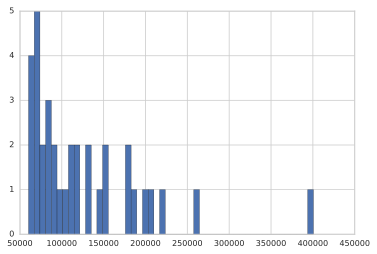

In [26]:
g = plt.hist(norec_regions.norec_end-norec_regions.norec_start, bins=50)

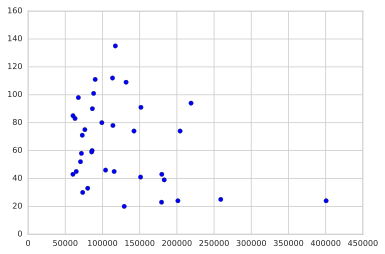

In [27]:
g = plt.scatter(norec_regions.norec_end-norec_regions.norec_start, norec_regions.nr_indivs)

Compute how likely is it for a 200kb haplotype to rise from 1 to at least `nr_indivs` in a pop of size $N$ in at most $1000$ generations without recombining before then:

In [28]:
# def freq_trajectory(N, n=1, s=0):
#     yield n
#     while N > n > 0:
#         n = numpy.random.binomial(N, n*(1+s)/((N-n)+(n)*(1+s)), 1)[0]
#         yield n

# def norec_freq_reached(N, allele_count, g, r, L, n=1, s=0):
#     min_allele_count_reached = 0
#     n_samples = 100000
#     for i in range(n_samples):
#         trajectory = list(freq_trajectory(N, n=1, s=0))
        
#         max_freq = max(trajectory[:g])
#         if max_freq >= allele_count:
#             nr_gens = trajectory[:g].index(max_freq) + 1
#             min_allele_count_reached += (1-(r*L))**nr_gens
#     return min_allele_count_reached / n_samples

In [29]:
# sanity check
#allele_freq_reached(N, N, 1000000)

In [30]:
# gens = range(10, 1000, 100)
# p = [norec_freq_reached(N, allele_count, g, r, L) for g in gens]
# g = plt.plot(gens, p, 'o')

In [31]:
# N = 2 * 2000 * 3/4
# r = 0.1e-8 # 1/10 cM/Mb
# gens = 1000
# L = 2e5
# allele_count = 0.5 * N

# norec_freq_reached(N, allele_count, gens, r, L)

Applying this to our data, we assume N and a low reocmbination rate, and try any number of generations

In [32]:
# tot_non_afr_indivs = sweep_data.loc[lambda df: df.region_1 != 'Africa'].indiv_1.unique().size

# records = list()
# for tup in norec_regions.itertuples():
#     L = tup.norec_end - tup.norec_start
#     allele_count = N * tup.nr_indivs / tot_non_afr_indivs
#     prob_norec = norec_freq_reached(N, allele_count, gens, r, L)
#     records.append((tup.norec_start, tup.norec_end, tup.nr_indivs, prob_norec))
# norec_probs = DataFrame.from_records(records, columns=['norec_start', 'norec_end', 'nr_indivs', 'prob_norec'])
# norec_probs.assign(length=lambda df: df.norec_end - df.norec_start)                                        

In [33]:
# norec_probs.to_hdf(results_dir / 'norec_probs.hdf', 'df', format="table", mode='w')

## Dating of non-recombined regions

In [40]:
file_index = dict()
for file_path in male_x_haploid_dir.glob('*.fa'):
    name = file_path.name.split('.')[0]
    file_index[name] = pyfaidx.Fasta(str(file_path), 
                                     strict_bounds=True, 
                                     one_based_attributes=False)
    
reference_index = pyfaidx.Fasta(str(reference_genome_file), 
                                 strict_bounds=True, 
                                 one_based_attributes=False)
    
def compute_pwdist(seq1, seq2, theta, idx=None):
    if idx is None:
        idx = list(range(len(seq1)))

    atgc = frozenset(['A', 'T', 'C', 'G'])
    L, m = 0, 0
    for a, b in ((seq1[i], seq2[i]) for i in idx):
        if a in atgc and (b == a or b in atgc):
            L += 1
            if a != b:
                m += 1
    
    return (m + 1) / (theta * L + 1)
    

def dist_matrix(seq_list, theta, idx=None):
    upper_trag_idx = list(zip(*numpy.triu_indices(len(seq_list), k=1)))
    seq_pairs = [(seq_list[i], seq_list[j]) for i, j in upper_trag_idx]
    condensed_mat = list()
    for seq1, seq2 in seq_pairs:
        condensed_mat.append(compute_pwdist(seq1, seq2, theta, idx))
    return condensed_mat


def get_alignmnet(sample_ids, start, end):
    assert start < end
    start, end = int(start), int(end)
    seq_list = list()
    name_list = list()

    for sample_id in sample_ids:
        name = sample_id + '-A'   
        seq_list.append(file_index[name]['X'][start:end].seq)
        name_list.append(name.replace('-A', ''))
        
    return name_list, seq_list


def get_tmrca(norec_start, norec_end, swept_indivs, theta):
    
    length = norec_end-norec_start
    name_list, alignment = get_alignmnet(swept_indivs, norec_start, norec_end)

    mat = dist_matrix(alignment, theta)
    dendro = linkage(mat, 'weighted')    
    tmrca = dendro[-1][2]

    nr_boot = 0
    boot = list()
    for i in range(nr_boot):
        boot_idx = numpy.random.choice(range(length), length, replace=True)
        mat = dist_matrix(alignment, theta, boot_idx)
        dendro = linkage(mat, 'weighted')    
        tmrca = dendro[-1][2]
        boot.append(tmrca)
        print(tmrca)
    if boot:
        conf = numpy.std(boot) * 1.96
    else:
        conf = numpy.nan

    return norec_start, norec_end, tmrca, conf

Empirical pi:

In [41]:
sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')
theta = sweep_data.loc[lambda df: (df.region_1 != 'Africa')].mean_dist.mean()
theta

0.00047241918545718592

This is a little high. Could be because sampling is not random, but uniformly across the world, resulting in more between population pairs than a random sample. It roughly corresponds to:

In [42]:
4 * 6e-10 * 25 * 10000 * 3 / 4

0.00045

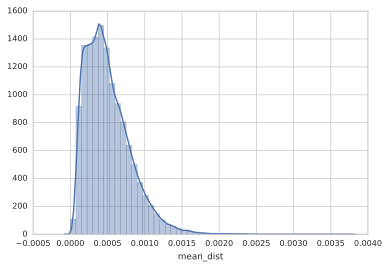

In [43]:
g = sns.distplot(sweep_data.loc[lambda df: (~numpy.isnan(df.mean_dist))].mean_dist)

In [44]:

def get_alignmnet(sample_ids, start, end):
    assert start < end
    start, end = int(start), int(end)
    seq_list = list()
    name_list = list()

    for sample_id in sample_ids:
        name = sample_id + '-A'   
        seq_list.append(file_index[name]['X'][start:end].seq)
        name_list.append(name.replace('-A', ''))
        
    return name_list, seq_list

In [45]:
#theta = 4 * 1.5e-8 * 10000 

# records = list()
# for tup in norec_regions.itertuples():
#     with Timer():
#         records.append(get_tmrca(int(tup.norec_start), 
#                              int(tup.norec_end), 
#                              tup.swept_indivs, 
#                              theta))

# scatter_func(get_alignmnet, dist_matrix, compute_pwdist)
# dview.scatter('file_index', file_index)

# records = dview.map_sync(get_tmrca,
#                          list(map(int, norec_regions.norec_start)), 
#                          list(map(int, norec_regions.norec_end)), 
#                          list(map(eval, norec_regions.swept_indivs)), 
#                          [theta] * len(norec_regions))

args_iter = zip(map(int, norec_regions.norec_start), 
                map(int, norec_regions.norec_end), 
                norec_regions.swept_indivs, 
                [theta] * len(norec_regions))
                
with Pool(cpu_count()) as p:
    records = p.starmap(get_tmrca, args_iter)

In [46]:
sweep_dates = DataFrame.from_records(records, columns=['norec_start', 'norec_end', 'tmrca', 'conf'])
sweep_dates

,norec_start,norec_end,tmrca,conf
0,11145945,11261627,0.211143,NaN
1,14622108,14726284,0.258299,NaN
2,17653260,17854643,0.120955,NaN
3,19801047,19891242,1518.078671,NaN
4,21248634,21380364,1529.359754,NaN
5,27969700,28098908,0.135168,NaN
6,35391518,35570941,0.133889,NaN
7,36241239,36301670,1457.794577,NaN
8,37379486,37521832,1534.424622,NaN
9,43325057,43385359,0.254806,NaN


In [47]:
sweep_dates.to_hdf(results_dir / 'sweep_dates.hdf', 'df', format="table", mode='w')

In [48]:
#sweep_dates = pandas.read_hdf(results_dir / 'sweep_dates.hdf')

(0, 60000)

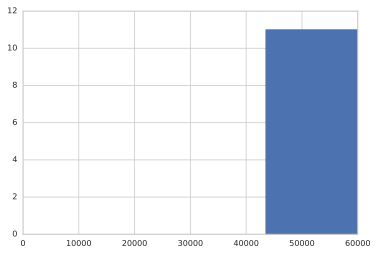

In [49]:
g = plt.hist(sweep_dates.tmrca * theta / (2 * 6e-10), bins = 150)
plt.xlim(0, 60000)

In [50]:
sweep_dates.head()

,norec_start,norec_end,tmrca,conf
0,11145945,11261627,0.211143,NaN
1,14622108,14726284,0.258299,NaN
2,17653260,17854643,0.120955,NaN
3,19801047,19891242,1518.078671,NaN
4,21248634,21380364,1529.359754,NaN


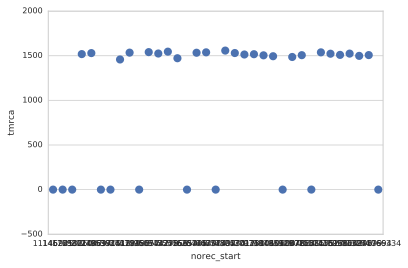

In [51]:
g = sns.pointplot(data=sweep_dates, x='norec_start', y='tmrca', join=False)

In [52]:
#g = plt.scatter(sweep_dates.norec_start, sweep_dates.tmrca * (2 * 10000 * 25))

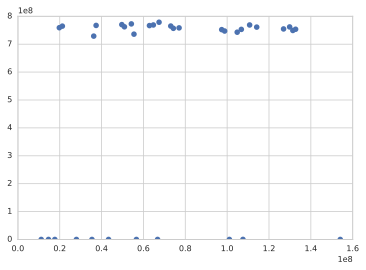

In [53]:
g = plt.errorbar(sweep_dates.norec_start, sweep_dates.tmrca * (2 * 10000 * 25), yerr=10000, fmt='o')

In [ ]:
# fig = plt.figure()
# dn = dendrogram(dendro)